### Load the libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from src.img_annotator import PetImgAnnotator
from src.dataset import DogsVsCatsDataset
# from dataloader import DogsVsCatsDataloader
import torch
from torch.utils.data.dataloader import default_collate
from torch.utils.data import DataLoader
# import torchvision
from src.net import Net
from torch.nn import BCELoss
import torch.optim as optim
# from tqdm import tqdm

### Create the Training and Testing DataLoaders

In [2]:
annotator = PetImgAnnotator(0, r"data\PetImages\Cat", r"data\PetImages\Dog")

train_split = 0.8
train_labels, test_labels = annotator.create_pet_img_annotations(train_split)
# train_labels = "src/dogs_cats_train_labels.csv"
# test_labels = "src/dogs_cats_test_labels.csv"

#### Create image Collation function

There are some corrupted image files in the this data set, which Python is not able to read properly. When this happens, an incorrectly sized batch is created, which the neural network can't process since its shape is mismatched to the expected shape given by the model architecture. As such, these images need to be ignored when putting together the batch.

In [12]:
def custom_collate(batch):
    # batch = list(filter(lambda x:x is not None, batch))
    new_batch = []
    for image, label in batch:
        if image != None:
            new_batch.append((image, label))
    return default_collate(new_batch)

In [13]:
bs = 16

traindata = DogsVsCatsDataset(train_labels)
testdata = DogsVsCatsDataset(test_labels)

# traindataloader = DogsVsCatsDataloader(traindata, batch_size = bs, shuffle = True)
# testdataloader = DogsVsCatsDataloader(testdata, batch_size = bs, shuffle = True)

traindataloader = DataLoader(
    traindata,
    batch_size = bs,
    shuffle = True,
    num_workers = 0,
    collate_fn = custom_collate
)

testdataloader = DataLoader(
    testdata,
    batch_size = bs,
    shuffle = True,
    num_workers = 0,
    collate_fn = custom_collate
)

In [14]:
# print an example of the data
dataiter = iter(traindataloader)
image, label = next(dataiter)
print(image.shape)
print(label)

torch.Size([16, 3, 32, 32])
tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])


### Create the Neural Network

In [15]:
net = Net()
loss_fn = BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

### Train the Network on the Training Data

Save the model's training loss per epoch in a .csv file, and save the model weights after training is completed

In [16]:
with open("train_loss_progress.csv", "a+") as train_loss:
    for epoch in range(2):
        running_loss = 0.0
        for inputs, labels in traindataloader:
            preds = net(inputs)
            optimizer.zero_grad()
            loss = loss_fn(preds, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(traindata)
        train_loss.write(f"{epoch+1},{epoch_loss}\n")

        

    # acc = 0
    # count = 0
    # for inputs, labels in testdataloader:
    #     y_pred = net(inputs)
    #     acc += (torch.argmax(y_pred, 1) == labels).float().sum()
    #     count += len(labels)
    # acc /= count
    # print("Epoch %d: model accuracy %.2f%%" % (epoch, acc*100))

c:\Users\Ravi\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


#### Plot the Results of Training

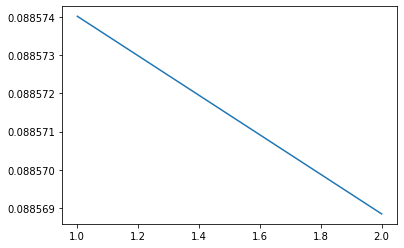

In [27]:
# train_loss = pd.read_csv("train_loss_progress.csv", header = None)

plt.plot(train_loss[0], train_loss[1]);

### Check the Model Performance on the Testing Data

In [8]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in testdataloader:
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels[:, 0]).sum().item()

 33%|███▎      | 102/313 [00:31<01:10,  2.99it/s]c:\Users\Ravi\Anaconda3\envs\pytorch\lib\site-packages\PIL\TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 313/313 [01:32<00:00,  3.38it/s]


In [9]:
print(f"Accuracy: {100 * correct // total}%")

Accuracy: 46%


In [56]:
with torch.no_grad():
    test_iter = iter(testdataloader)
    example_test_imgs, example_test_labels = next(test_iter)

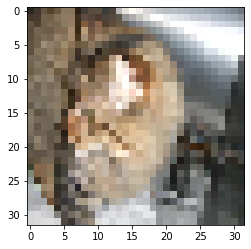

In [57]:
plt.imshow(  example_test_imgs[0].permute(1, 2, 0)  )

In [110]:
example_outputs = net(example_test_imgs)
example_predictions = torch.argmax(example_outputs, dim = 1)

In [105]:
example_test_labels

tensor([[1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [0., 1.],
        [0., 1.],
        [1., 0.],
        [0., 1.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.],
        [1., 0.]])

In [108]:
example_test_labels[:, 1] # take index 1, which contain the correct singleton labels

tensor([0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0.])

In [124]:
example_test_labels[:, 1] == example_predictions

tensor([False, False, False,  True, False,  True,  True, False, False, False,
         True, False,  True, False,  True,  True])